<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/375_Understanding_Model_Predictions_with_SHAP_XGBoost_vs_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/eLrtufRomh8

# **Understanding Model Predictions with SHAP: XGBoost vs Neural Networks**


## **What is SHAP and why do we need it?**

SHAP stands for SHapley Additive exPlanations. It comes from game theory, specifically from something called Shapley values. Let me explain with a simple example.

Imagine you have a team of 5 people working on a project, and they win first prize of $1000. How should they divide the money? Should everyone get equal share, or should it be based on who contributed the most? But how do we quantify who contributed how much?

The Shapley value approach says: let's see what happens when we remove one person at a time from the team. If removing person A causes the team's performance to drop significantly, then person A contributed a lot. We do this for all possible combinations of team members to fairly calculate each person's contribution.

SHAP applies this same concept to machine learning. When a model makes a prediction, SHAP tells us: "This feature increased the prediction by X amount, that feature decreased it by Y amount" - giving each feature its fair share of credit (or blame) for the final prediction.



### **SHAP Concept: A Simple Hand Calculation**

Let's say we have a team of 3 people (Alice, Bob, Charlie) working on projects, and we want to fairly distribute a $1000 bonus based on their contributions.

**Project outcomes:**
- Empty team (no one): \$0 revenue
- Alice alone: \$300
- Bob alone: \$200
- Charlie alone: \$100
- Alice + Bob: \$600
- Alice + Charlie: \$500
- Bob + Charlie: \$400
- All three together: \$1000

**Traditional approach** might say: "The team made \$1000, so everyone gets \$333.33"

**Shapley value approach** says: "Let's see what happens when we add/remove each person from different team combinations"

**Calculating Alice's Shapley value:**

We look at all possible scenarios where Alice joins:
1. Alice joins empty team: adds \$300 (from \$0 → \$300)
2. Alice joins Bob: adds \$400 (from \$200 → \$600)
3. Alice joins Charlie: adds \$400 (from \$100 → \$500)
4. Alice joins Bob+Charlie: adds \$600 (from \$400 → \$1000)

Average Alice's marginal contribution: (300 + 400 + 400 + 600) / 4 = **\$425**

Similarly:
- **Bob's Shapley value: \$375**
- **Charlie's Shapley value: \$200**

Total: \$425 + \$375 + \$200 = \$1000

**Key insight:** Alice gets more than Bob even though Bob alone produces \$200 vs Alice's \$300, because Alice creates MORE VALUE when working with others (synergy effect). This is exactly what SHAP does with features in machine learning - it measures each feature's contribution accounting for all possible combinations with other features.

In ML terms:
- Team members = Features
- Revenue = Model prediction
- Bonus distribution = SHAP values

**You might be wondering: How do we know Alice alone produces \$300, or Alice+Bob produces \$600?**

In the real world, you'd need to run actual experiments or look at historical data - have Alice work on projects alone, have Alice and Bob work together, and measure the outcomes.

But here's the beauty of machine learning: **the trained model can instantly tell us!** We don't need new experiments. We can simply ask the model:
```python
# Example: Predicting house price with 3 features
# Features: square_feet=2000, bedrooms=3, age=10

# "Alice alone" = Only square_feet, set others to baseline/zero
prediction_1 = model.predict([2000, baseline_bedrooms, baseline_age])

# "Alice + Bob" = square_feet + bedrooms, age at baseline
prediction_2 = model.predict([2000, 3, baseline_age])

# All three features
prediction_3 = model.predict([2000, 3, 10])
```

The trained model already "knows" the relationships between features and predictions, so we can instantly test any combination of features. SHAP uses this to calculate each feature's marginal contribution across all possible feature combinations - giving us the fair "credit distribution" for each feature's role in the prediction.

**Now, let's use SHAP with XGBoost on the breast cancer dataset** to understand not just what the model predicts, but WHY it makes those predictions.

## **About the dataset:**

I'm using the Wisconsin Breast Cancer dataset, which contains measurements from cell nuclei present in breast mass images. The goal is to classify tumors as malignant (cancerous) or benign (non-cancerous). The dataset has 30 features including radius, texture, perimeter, area, smoothness, and other characteristics of cell nuclei.

In [ ]:
# Latest xgboost giving some issues when working with shap, so rollingback.
!pip install xgboost==2.0.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 1.4 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.1.1
    Uninstalling xgboost-3.1.1:
      Successfully uninstalled xgboost-3.1.1


Dataset shape: (569, 30)

Target distribution:
target
1    357
0    212
Name: count, dtype: int64

0 = Malignant, 1 = Benign

First 5 rows:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280         

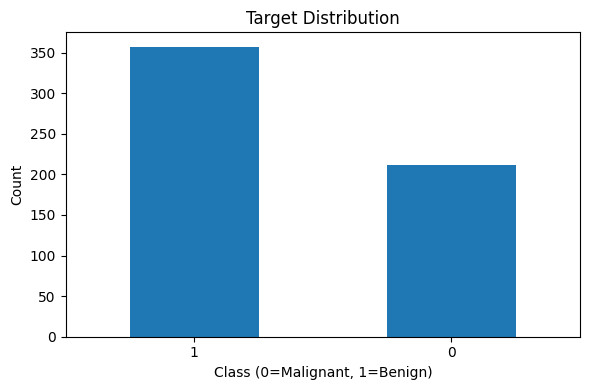

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import xgboost as xgb
import shap

# Load the breast cancer dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

print(f"Dataset shape: {X.shape}")
print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\n0 = Malignant, 1 = Benign")

# Let me show the first few rows and basic statistics
print("\nFirst 5 rows:")
print(X.head())
print("\nBasic statistics:")
print(X.describe())

# Plot target distribution
plt.figure(figsize=(6, 4))
y.value_counts().plot(kind='bar')
plt.title('Target Distribution')
plt.xlabel('Class (0=Malignant, 1=Benign)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# **Train/test split and XGBoost model**

Here I'm splitting the data into training (80%) and testing (20%) sets. Then I'll train an XGBoost classifier, which is a powerful tree-based algorithm that works well for classification problems.

After training, I'm checking the model's accuracy and plotting a confusion matrix to see how well it performs. The confusion matrix shows us true positives, true negatives, false positives, and false negatives - giving us a complete picture of model performance.

Training set size: 455
Test set size: 114

Model Accuracy: 0.9561


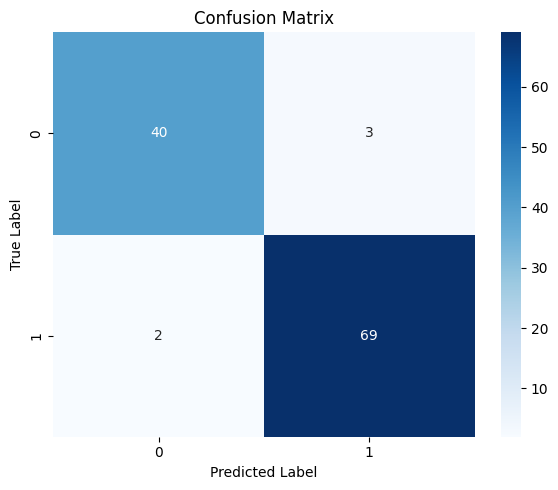

In [ ]:
# Let me split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Now I'll train an XGBoost classifier
model = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Let me check the model performance
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# **Predict a single sample (before SHAP)**

Now let me pick one sample from the test set and make a prediction. I'll show you what the model predicts and with what confidence level.

But here's the important question: WHY did the model make this prediction? What features drove this decision? This is where SHAP comes in. Traditional machine learning models are like black boxes - they give you an answer but don't explain their reasoning. SHAP opens up that black box.

In [ ]:
# Let me pick one sample from the test set and make a prediction
sample_idx = 0
sample = X_test.iloc[sample_idx:sample_idx+1]

# Get the prediction
pred_proba = model.predict_proba(sample)[0]
prediction = model.predict(sample)[0]

print(f"Sample index: {sample_idx}")
print(f"True label: {y_test.iloc[sample_idx]} ({'Malignant' if y_test.iloc[sample_idx] == 0 else 'Benign'})")
print(f"Predicted: {prediction} ({'Malignant' if prediction == 0 else 'Benign'})")
print(f"Prediction probability: {pred_proba[1]:.4f} (probability of Benign)")
print(f"\nBut WHY did the model make this prediction? Let me use SHAP to explain...")

Sample index: 0
True label: 1 (Benign)
Predicted: 1 (Benign)
Prediction probability: 0.9897 (probability of Benign)

But WHY did the model make this prediction? Let me use SHAP to explain...


# **Traditional feature importance**

XGBoost and other tree-based algorithms give us feature importance scores. These scores tell us which features are generally important across all predictions in the dataset.

However, these importance scores have limitations:
1. They show global importance, not why a specific prediction was made
2. They don't tell us the direction of impact (does high value increase or decrease prediction?)
3. They don't show how features interact with each other

This is why we need SHAP - to get deeper insights into individual predictions.

Top 10 features by XGBoost importance:
                 feature  importance
7    mean concave points    0.300990
27  worst concave points    0.189997
22       worst perimeter    0.161778
20          worst radius    0.056892
23            worst area    0.035501
26       worst concavity    0.028123
0            mean radius    0.027829
21         worst texture    0.026581
16       concavity error    0.021639
1           mean texture    0.019897


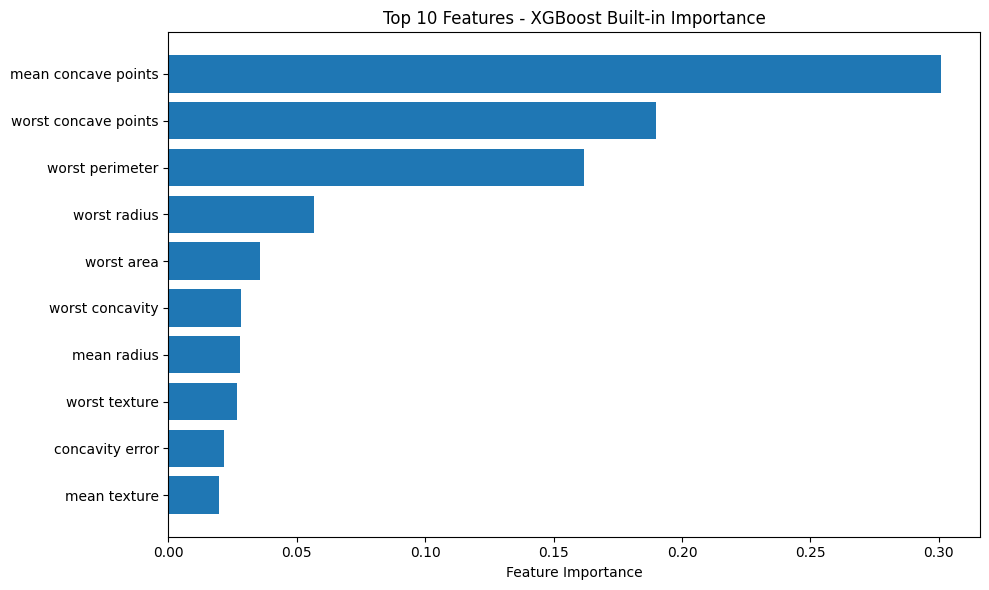

In [ ]:
# XGBoost and other tree-based algorithms give us feature importance. Let me calculate and plot them
feature_importance = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 10 features by XGBoost importance:")
print(feature_importance_df.head(10))

# Plot top 10 features
plt.figure(figsize=(10, 6))
top_features = feature_importance_df.head(10)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Features - XGBoost Built-in Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# **SHAP on training data (baseline)**

Now I'm calculating SHAP values for all training data. This gives us a baseline understanding of how features contribute to predictions across the entire dataset.

The base value (expected value) represents what the model would predict if we didn't know anything about the features - it's essentially the average prediction across all training samples.

The summary plot shows global feature importance based on SHAP values. Each dot represents a sample, color represents feature value (red=high, blue=low), and position on x-axis shows the SHAP value (impact on prediction). This tells us not just which features are important, but also how their values affect predictions.

SHAP values shape: (455, 30)
Base value (baseline prediction): 0.5389


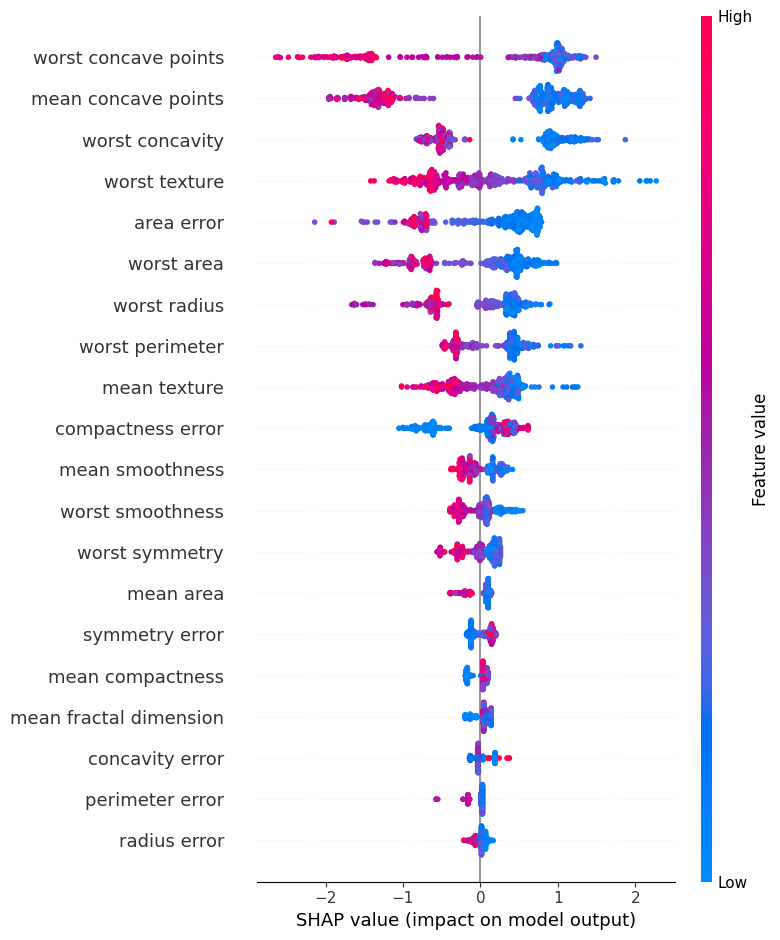

In [ ]:
# Now let me use SHAP to get a better understanding of feature contributions
# I'll create a SHAP explainer for our XGBoost model
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for all training data - this gives us the baseline
shap_values = explainer(X_train)

print(f"SHAP values shape: {shap_values.values.shape}")
print(f"Base value (baseline prediction): {explainer.expected_value:.4f}")

# Summary plot shows global feature importance based on SHAP values
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_train, show=False)
plt.tight_layout()
plt.show()



# **SHAP for single prediction**

Here's where SHAP really shines. I'm taking the single sample we predicted earlier and using SHAP to explain exactly why the model made that specific prediction.

The waterfall plot shows how we go from the baseline prediction to the final prediction. Let me explain what you're seeing:

- **E[f(X)] = 0.539**: This is our baseline (expected value) - the average prediction the model makes across all training samples, which is 53.9% probability of being Benign.

- **f(x) = 4.561**: This is the final prediction for our sample in log-odds space. When we convert this to probability, we get 98.9% probability of being Benign.

- **Feature values and SHAP values**: For each feature, you see two numbers:
  - The left number (e.g., 0.102 for worst concave points) is the actual feature value for this sample
  - The right number (e.g., +1.07) is the SHAP value showing how much this feature pushed the prediction in log-odds space
  - Red bars push toward Benign (positive SHAP values)
  - Blue bars push toward Malignant (negative SHAP values)

For example, "worst concave points = 0.102" with SHAP value +1.07 means: this particular sample has a worst concave points value of 0.102, and this feature strongly pushed the prediction toward Benign by 1.07 in log-odds space (which translates to about 23 percentage points increase in probability).

The waterfall starts at the baseline and adds each feature's contribution step by step until we reach the final prediction.

The force plot is another way to visualize the same information - features pushing toward Benign are shown in red, features pushing toward Malignant are shown in blue.

Sample index: 0
True label: 1 (Benign)
Predicted: 1 (Benign)
Prediction probability: 0.9897 (probability of Benign)


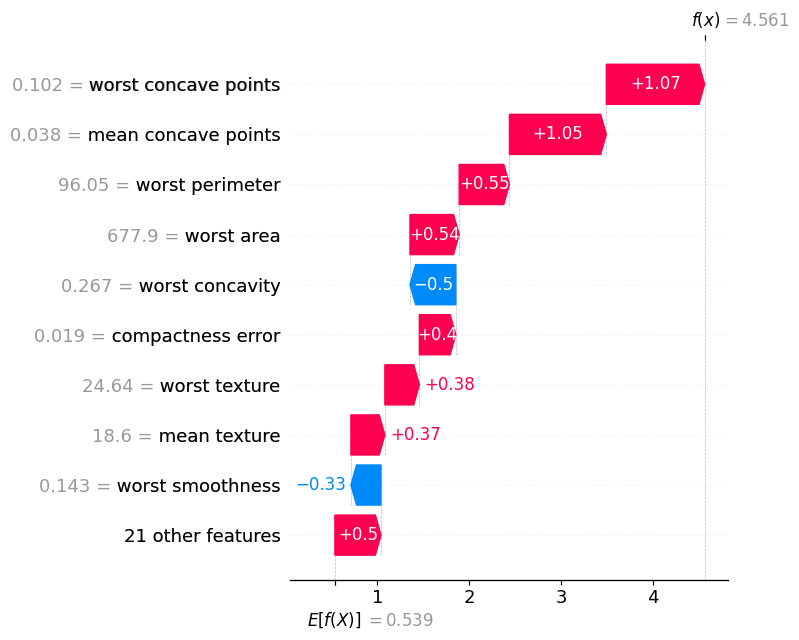

In [ ]:
# Let me pick one sample from the test set and explain its prediction
sample_idx = 0
sample = X_test.iloc[sample_idx:sample_idx+1]

# Get the prediction probability
pred_proba = model.predict_proba(sample)[0]
prediction = model.predict(sample)[0]

print(f"Sample index: {sample_idx}")
print(f"True label: {y_test.iloc[sample_idx]} ({'Malignant' if y_test.iloc[sample_idx] == 0 else 'Benign'})")
print(f"Predicted: {prediction} ({'Malignant' if prediction == 0 else 'Benign'})")
print(f"Prediction probability: {pred_proba[1]:.4f} (probability of Benign)")

# Calculate SHAP values for this single sample
shap_values_sample = explainer(sample)

# Waterfall plot shows how we got from baseline to final prediction
plt.figure(figsize=(10, 8))
shap.plots.waterfall(shap_values_sample[0], show=False)
plt.tight_layout()
plt.show()

# # Force plot is an alternative way to visualize the same information
# shap.force_plot(explainer.expected_value, shap_values_sample.values[0], sample.iloc[0], matplotlib=True, show=False)
# plt.tight_layout()
# plt.show()

# **NLP explanations**

Finally, I'm converting SHAP values into natural language explanations that anyone can understand, even without technical background.

One important thing to understand: SHAP values work in log-odds space, not probability space. So I need to convert them properly to show how each feature changes the probability. I'm doing this step-by-step conversion to show how we go from the baseline probability through each feature's contribution to reach the final prediction.

This makes the model's decision-making process transparent and interpretable - crucial for medical applications, financial decisions, or any domain where we need to trust and verify AI predictions.

In [ ]:
def logit(p):
    """Convert probability to log-odds"""
    return np.log(p / (1 - p))

def sigmoid(x):
    """Convert log-odds to probability"""
    return 1 / (1 + np.exp(-x))

def generate_explanation(shap_values, feature_names, feature_values, base_value, prediction_proba, class_names=['Malignant', 'Benign']):
    """
    I'll generate a human-readable explanation from SHAP values
    Converting from log-odds space to probability space step by step
    """
    # Get SHAP values and sort by absolute value
    shap_contribution = shap_values.values[0]
    feature_impacts = list(zip(feature_names, feature_values.values[0], shap_contribution))
    feature_impacts_sorted = sorted(feature_impacts, key=lambda x: abs(x[2]), reverse=True)

    # Base value is already in probability space
    base_prob = base_value

    # Start building the explanation
    predicted_class = class_names[1] if prediction_proba > 0.5 else class_names[0]
    explanation = f"The model predicts this sample is {predicted_class} with {prediction_proba*100:.1f}% confidence.\n\n"

    explanation += f"Starting from a baseline probability of {base_prob*100:.1f}%, here's how the TOP 5 features influenced this prediction:\n\n"

    # Convert step by step through probability space
    current_log_odds = logit(base_prob)

    for i, (feature, value, shap_val) in enumerate(feature_impacts_sorted[:5]):
        # Calculate probability before and after this feature
        prob_before = sigmoid(current_log_odds)
        current_log_odds += shap_val
        prob_after = sigmoid(current_log_odds)

        prob_change = (prob_after - prob_before) * 100
        direction = "increased" if prob_change > 0 else "decreased"

        explanation += f"{i+1}. {feature} = {value:.3f}: {direction} probability by {abs(prob_change):.1f} percentage points (from {prob_before*100:.1f}% to {prob_after*100:.1f}%)\n"

    # Show contribution from remaining features
    prob_after_top5 = sigmoid(current_log_odds)
    remaining_contribution = (prediction_proba - prob_after_top5) * 100

    explanation += f"\nRemaining {len(feature_impacts) - 5} features contributed: {remaining_contribution:+.1f} percentage points"
    explanation += f"\n\nFinal prediction probability: {prediction_proba*100:.1f}% for {predicted_class}"

    return explanation

# Generate explanation for our sample
explanation_text = generate_explanation(
    shap_values_sample,
    X.columns,
    sample,
    explainer.expected_value,
    pred_proba[1]
)

print("="*80)
print("NATURAL LANGUAGE EXPLANATION")
print("="*80)
print(explanation_text)

NATURAL LANGUAGE EXPLANATION
The model predicts this sample is Benign with 99.0% confidence.

Starting from a baseline probability of 53.9%, here's how the TOP 5 features influenced this prediction:

1. worst concave points = 0.102: increased probability by 23.4 percentage points (from 53.9% to 77.3%)
2. mean concave points = 0.038: increased probability by 13.4 percentage points (from 77.3% to 90.7%)
3. worst perimeter = 96.050: increased probability by 3.7 percentage points (from 90.7% to 94.4%)
4. worst area = 677.900: increased probability by 2.2 percentage points (from 94.4% to 96.6%)
5. worst concavity = 0.267: decreased probability by 2.1 percentage points (from 96.6% to 94.6%)

Remaining 25 features contributed: +4.4 percentage points

Final prediction probability: 99.0% for Benign


#What about deep learning?
## Can SHAP be used to explain deep learning results?

## **SHAP with Different Model Types**

One of the powerful aspects of SHAP is that it works across different types of machine learning models. SHAP provides different explainers for different model architectures:

- **TreeExplainer**: Optimized for tree-based models (XGBoost, Random Forest, LightGBM, CatBoost). This is very fast and exact for tree models.
- **DeepExplainer**: For deep learning models using TensorFlow or PyTorch. Uses DeepLIFT algorithm under the hood.
- **GradientExplainer**: Another option for neural networks, uses integrated gradients approach.
- **KernelExplainer**: Model-agnostic, works with any model but is slower. Uses a special weighted linear regression approach.
- **LinearExplainer**: For linear models like linear regression and logistic regression.

The same Shapley value principle from game theory applies to all these model types - fairly distributing the "credit" for a prediction among all features. However, the computational approach differs based on model architecture.

## **XGBoost vs Neural Networks for Explainability**

While SHAP works with both XGBoost and neural networks, there are important differences:

1. **Interpretability**: XGBoost naturally provides clearer feature importance and interactions because it's based on decision trees. Neural networks are more of a "black box" even with SHAP.

2. **SHAP value magnitude**: Tree-based models typically produce larger, more distinct SHAP values. Neural networks often have smaller, more distributed SHAP values across many features.

3. **Computation speed**: TreeExplainer for XGBoost is extremely fast. DeepExplainer for neural networks is slower and requires a background dataset.

4. **Stability**: XGBoost SHAP explanations tend to be more stable and consistent. Neural network explanations can vary based on the background data you choose.

For applications where explainability is critical (medical, financial, legal domains), tree-based models like XGBoost are often preferred because they're inherently more interpretable and their SHAP explanations are clearer and more reliable.



## **Building the Neural Network**

Now let me build a neural network on the same breast cancer dataset. Neural networks require normalized input data, so I'll scale the features first. I'm creating a simple feedforward network with dropout layers to prevent overfitting.

Training data shape: (455, 30)
Number of features: 30

Neural Network Architecture:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,609 (18.00 KB)

 Trainable params: 4,609 (18.00 KB)

 Non-trainable params: 0 (0.00 B)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Neural Network Accuracy: 0.9825


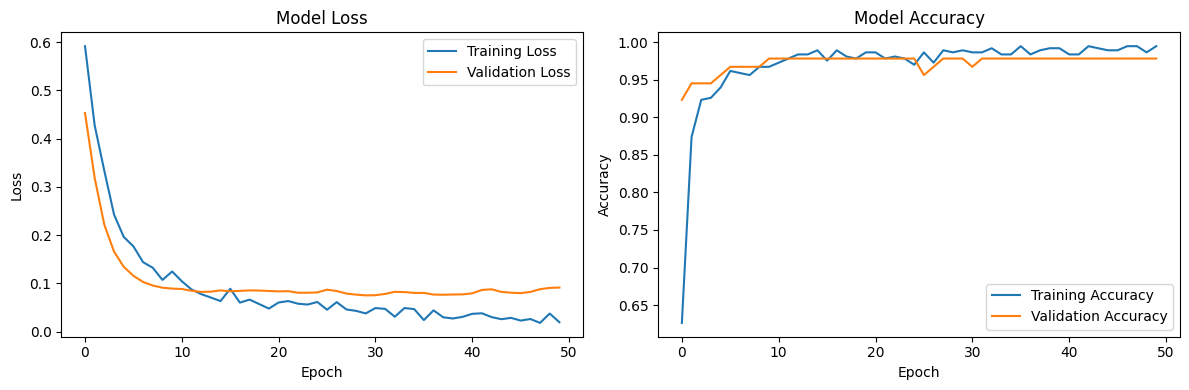

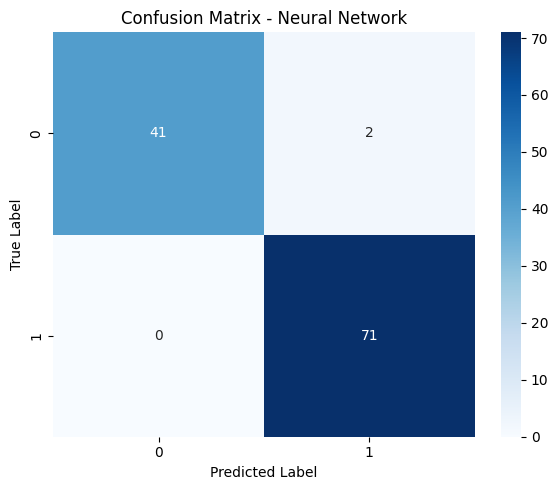

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

# Neural networks work better with normalized data, so let me scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training data shape: {X_train_scaled.shape}")
print(f"Number of features: {X_train_scaled.shape[1]}")

# Now let me build a simple neural network
model_nn = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_nn.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

print("\nNeural Network Architecture:")
model_nn.summary()

# Train the model
history = model_nn.fit(X_train_scaled, y_train,
                       epochs=50,
                       batch_size=32,
                       validation_split=0.2,
                       verbose=0)

# Evaluate the model
y_pred_nn = (model_nn.predict(X_test_scaled) > 0.5).astype(int).flatten()
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print(f"\nNeural Network Accuracy: {accuracy_nn:.4f}")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Model Loss')
ax1.legend()

ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Model Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

# Confusion matrix for neural network
cm_nn = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Neural Network')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## **Predict with Neural Network (before SHAP)**

Let me make a prediction on the same sample we used for XGBoost. This way I can compare how both models arrive at their predictions and how their explanations differ.

Notice that I'm using the scaled version of the data (X_test_scaled) because neural networks were trained on normalized features, unlike XGBoost which can work with raw values.

In [ ]:
# Let me use the same sample we used for XGBoost
sample_nn = X_test_scaled[sample_idx:sample_idx+1]

# Get the prediction
pred_proba_nn = model_nn.predict(sample_nn, verbose=0)[0][0]
prediction_nn = 1 if pred_proba_nn > 0.5 else 0

print(f"Sample index: {sample_idx}")
print(f"True label: {y_test.iloc[sample_idx]} ({'Malignant' if y_test.iloc[sample_idx] == 0 else 'Benign'})")
print(f"Predicted: {prediction_nn} ({'Malignant' if prediction_nn == 0 else 'Benign'})")
print(f"Prediction probability: {pred_proba_nn:.4f} (probability of Benign)")
print(f"\nNow let me use SHAP to explain this neural network prediction...")

Sample index: 0
True label: 1 (Benign)
Predicted: 1 (Benign)
Prediction probability: 0.9874 (probability of Benign)

Now let me use SHAP to explain this neural network prediction...


## **SHAP with DeepExplainer on training data**

Now I'm using SHAP's DeepExplainer to understand how the neural network makes predictions globally across the training data.

## **What is DeepExplainer?**

DeepExplainer is SHAP's explainer specifically designed for deep neural networks. It's based on an algorithm called DeepLIFT (Deep Learning Important FeaTures), which was developed to explain predictions from deep learning models.

Here's how DeepExplainer works:

1. **Background dataset**: It requires a representative sample of your training data (called background or reference data). This represents "typical" or "baseline" inputs.

2. **Comparison approach**: For each prediction, DeepExplainer compares the neural network's activation patterns when processing your input versus the background data. It tracks how signals propagate through the network layers.

3. **Backpropagation of contributions**: It uses a modified backpropagation method to trace back each neuron's contribution to the final prediction, and aggregates these to compute each input feature's SHAP value.

4. **Speed vs accuracy tradeoff**: DeepExplainer is faster than the model-agnostic KernelExplainer but makes some approximations. It works well for feedforward networks, CNNs, and some RNNs.

The key advantage of DeepExplainer over simply looking at gradients is that it properly handles the baseline comparison - showing how features contribute relative to a typical input, not just the local gradient at that point. This gives more meaningful explanations for understanding "why this prediction versus the average."


So, to summarize, DeepExplainer requires a "background dataset" - a sample of training data that represents the typical input distribution. SHAP uses this background to compute feature contributions by comparing predictions with and without each feature.

The summary plot here shows feature importance across all samples, similar to what we saw with XGBoost. However, you'll notice the SHAP values are much smaller in magnitude - this is normal for neural networks because they distribute the prediction across many neurons and layers, resulting in more diffused feature contributions.

/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(100, 30))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(200, 30))']
  warnings.warn(msg)


SHAP values shape: (455, 30, 1)
SHAP values range: min=-0.3267, max=0.1891


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(455, 30))']
  warnings.warn(msg)


<Figure size 1000x800 with 0 Axes>

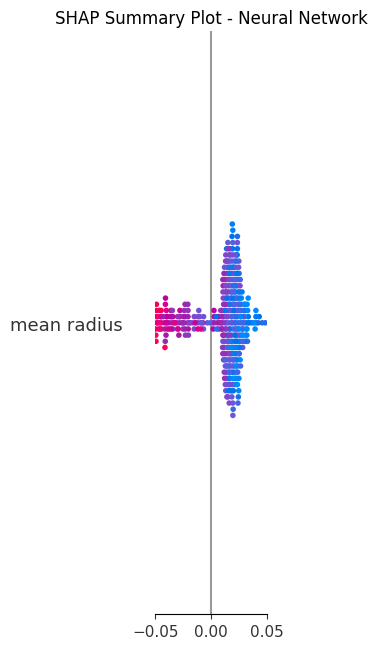

In [ ]:
# For neural networks, I'll use DeepExplainer
# DeepExplainer needs a background dataset - I'll use a sample of training data
background = X_train_scaled[:100]  # Using 100 samples as background

# Create the DeepExplainer
explainer_nn = shap.DeepExplainer(model_nn, background)

# Calculate SHAP values for a subset of training data (computing for all takes time)
X_train_subset = X_train_scaled[:500]
shap_values_nn = explainer_nn.shap_values(X_train_subset)

# DeepExplainer returns a list, get the first element
shap_values_nn_array = shap_values_nn[0] if isinstance(shap_values_nn, list) else shap_values_nn

print(f"SHAP values shape: {shap_values_nn_array.shape}")
print(f"SHAP values range: min={shap_values_nn_array.min():.4f}, max={shap_values_nn_array.max():.4f}")

# Summary plot for neural network with expanded x-axis
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_nn_array, X_train_subset, feature_names=X.columns.tolist(), show=False)
plt.xlim(-0.05, 0.05)  # Expand the x-axis range to make the plot more readable
plt.title('SHAP Summary Plot - Neural Network')
plt.tight_layout()
plt.show()

## **SHAP for single prediction with Neural Network**

Here I'm explaining the same single prediction using SHAP, just like I did with XGBoost. This allows for a direct comparison between the two models.

The waterfall plot shows how each feature contributes to moving from the baseline prediction to the final prediction. Notice that:
- The SHAP values are much smaller (0.01-0.04) compared to XGBoost (0.5-1.0)
- The neural network spreads importance across more features
- The baseline (E[f(X)]) is different from XGBoost because it's based on the neural network's average prediction

Even though the magnitude is different, the interpretation remains the same: positive SHAP values (red) push toward Benign, negative values (blue) push toward Malignant.

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1, 30))']
  warnings.warn(msg)


Sample index: 0
True label: 1 (Benign)
Neural Network Predicted: 1 (Benign)
Prediction probability: 0.9874 (probability of Benign)
Base value (baseline prediction): 0.6758

SHAP values shape after flattening: (30,)
Sample SHAP values range: min=-0.0070, max=0.0391

Top 10 features by absolute SHAP value:
                 feature  shap_value
21         worst texture    0.039145
23            worst area    0.033606
20          worst radius    0.029262
0            mean radius    0.028538
22       worst perimeter    0.028197
27  worst concave points    0.024371
7    mean concave points    0.021140
3              mean area    0.019950
26       worst concavity    0.017368
2         mean perimeter    0.014085


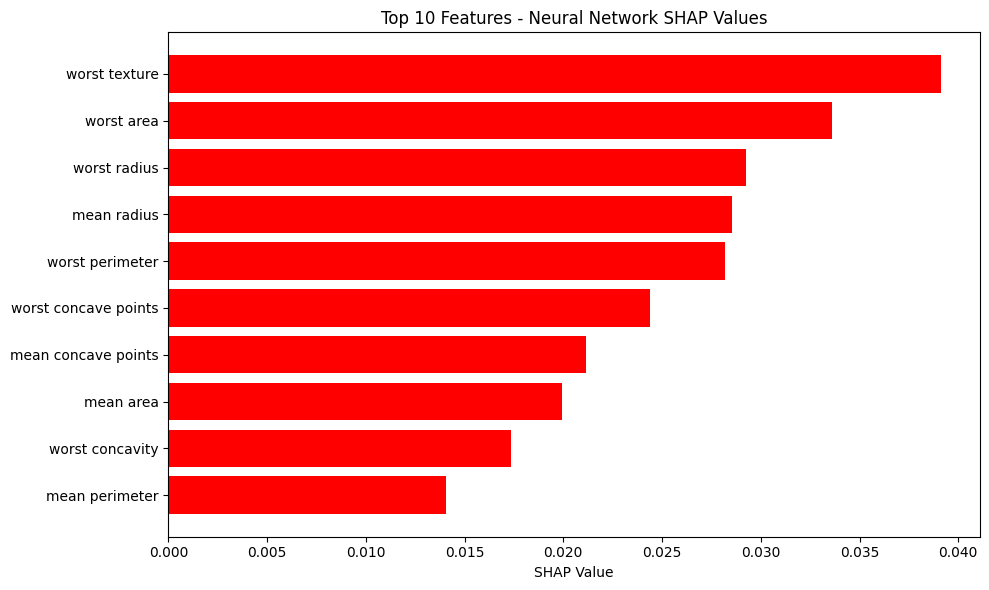

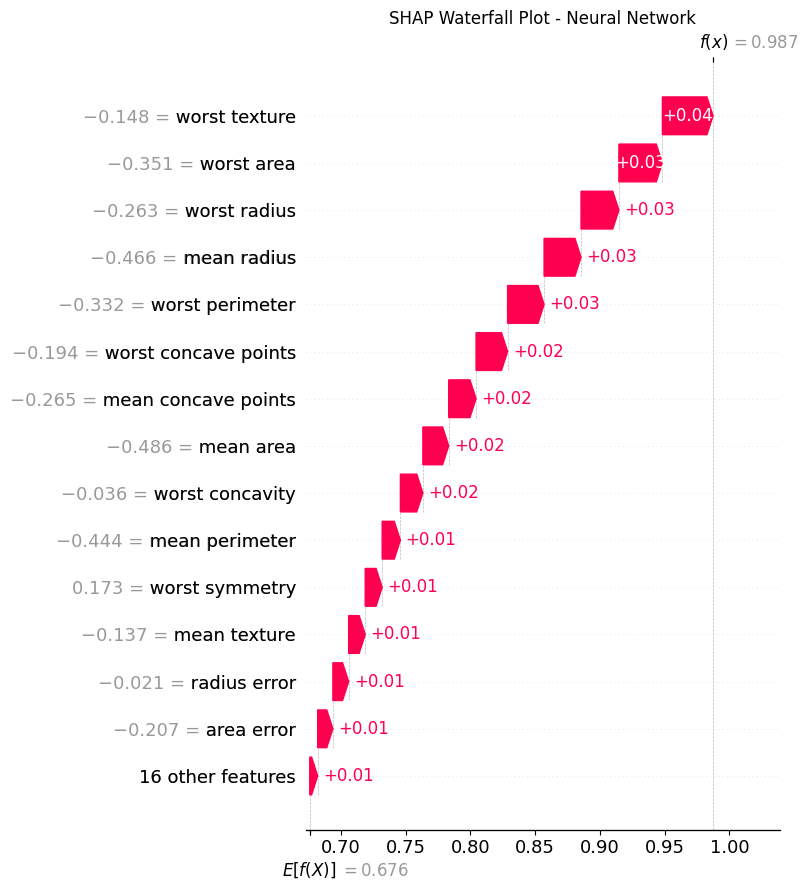

In [ ]:
# Calculate SHAP values for the same sample we've been analyzing
shap_values_sample_nn = explainer_nn.shap_values(sample_nn)

print(f"Sample index: {sample_idx}")
print(f"True label: {y_test.iloc[sample_idx]} ({'Malignant' if y_test.iloc[sample_idx] == 0 else 'Benign'})")
print(f"Neural Network Predicted: {prediction_nn} ({'Malignant' if prediction_nn == 0 else 'Benign'})")
print(f"Prediction probability: {pred_proba_nn:.4f} (probability of Benign)")

# Get the base value - convert from tensor if needed
base_value_nn = float(explainer_nn.expected_value[0]) if isinstance(explainer_nn.expected_value, (list, np.ndarray)) else float(explainer_nn.expected_value)

print(f"Base value (baseline prediction): {base_value_nn:.4f}")

# Flatten the SHAP values properly
shap_vals = shap_values_sample_nn[0].flatten()
print(f"\nSHAP values shape after flattening: {shap_vals.shape}")
print(f"Sample SHAP values range: min={shap_vals.min():.4f}, max={shap_vals.max():.4f}")

# Create a bar plot showing top 10 features
shap_df = pd.DataFrame({
    'feature': X.columns,
    'shap_value': shap_vals
}).sort_values('shap_value', key=abs, ascending=False).head(10)

print("\nTop 10 features by absolute SHAP value:")
print(shap_df)

plt.figure(figsize=(10, 6))
colors = ['red' if x > 0 else 'blue' for x in shap_df['shap_value']]
plt.barh(shap_df['feature'], shap_df['shap_value'], color=colors)
plt.xlabel('SHAP Value')
plt.title('Top 10 Features - Neural Network SHAP Values')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Try waterfall plot with the Explanation object
shap_explanation = shap.Explanation(
    values=shap_vals,
    base_values=base_value_nn,
    data=sample_nn[0],
    feature_names=X.columns.tolist()
)

plt.figure(figsize=(10, 8))
shap.plots.waterfall(shap_explanation, show=False, max_display=15)
plt.title('SHAP Waterfall Plot - Neural Network')
plt.tight_layout()
plt.show()

## **Compare XGBoost vs Neural Network explanations**

Finally, let me create a side-by-side comparison of how XGBoost and the Neural Network explain the same prediction.

Key observations from this comparison:

1. **Different feature priorities**: XGBoost heavily relies on "worst concave points" and "mean concave points", while the neural network gives more importance to "worst radius" and "worst area".

2. **SHAP value magnitude**: XGBoost has SHAP values ranging from -0.5 to 1.0, while neural network values are much smaller (0.01-0.04). This doesn't mean one is "better" - it's just how the models work internally.

3. **Consistency**: Both models arrive at similar predictions (~99% Benign), but through different reasoning paths. XGBoost focuses on fewer, more impactful features, while the neural network distributes importance more evenly.

4. **Interpretability**: XGBoost's explanation is clearer and easier to understand, which is why tree-based models are preferred in domains where explainability is crucial.

This comparison demonstrates that SHAP provides a universal framework for understanding model predictions across different architectures, even though the nature of explanations varies by model type.

Top 10 Features Comparison:
            Feature_XGB  SHAP_XGB            Feature_NN   SHAP_NN
0  worst concave points  1.069607         worst texture  0.039145
1   mean concave points  1.053682            worst area  0.033606
2       worst perimeter  0.547037          worst radius  0.029262
3            worst area  0.535019           mean radius  0.028538
4       worst concavity -0.498579       worst perimeter  0.028197
5     compactness error  0.396568  worst concave points  0.024371
6         worst texture  0.375334   mean concave points  0.021140
7          mean texture  0.369229             mean area  0.019950
8      worst smoothness -0.327315       worst concavity  0.017368
9          worst radius  0.243773        mean perimeter  0.014085


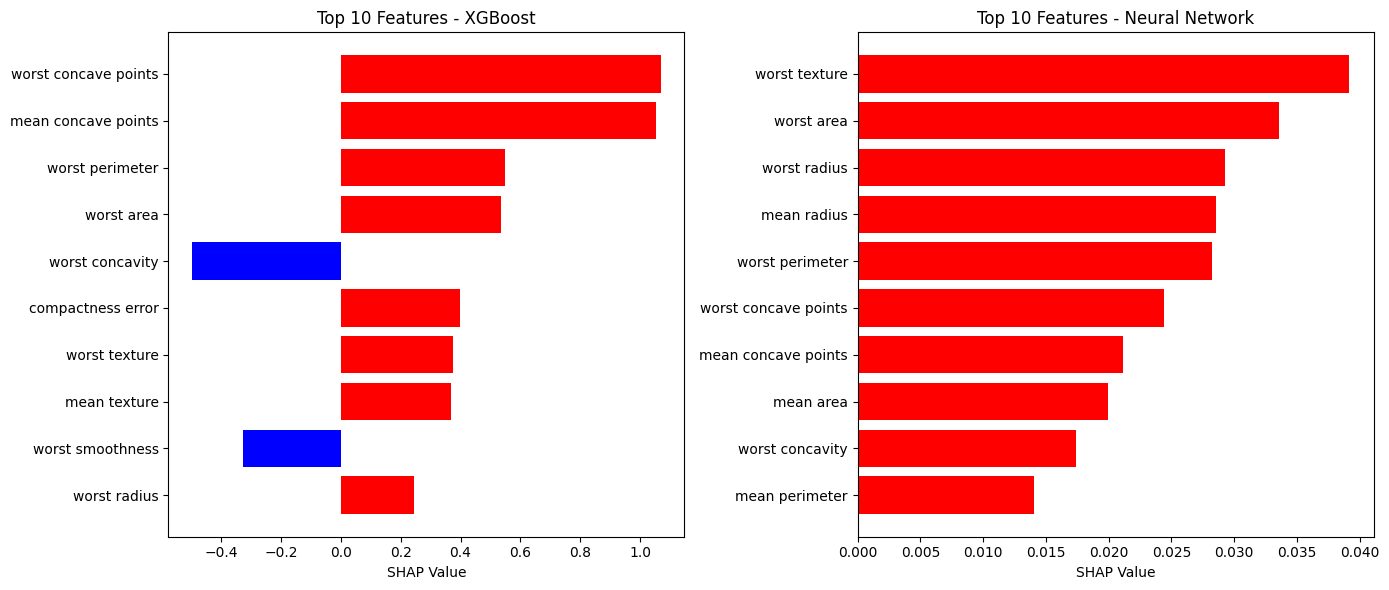


XGBoost Prediction: 0.9897 (Benign probability)
Neural Network Prediction: 0.9874 (Benign probability)


In [ ]:
# Let me create a comparison of top features from both models
# XGBoost SHAP values for the sample
xgb_shap = shap_values_sample.values[0]
xgb_features = list(zip(X.columns, xgb_shap))
xgb_features_sorted = sorted(xgb_features, key=lambda x: abs(x[1]), reverse=True)[:10]

# Neural Network SHAP values for the sample (already flattened)
nn_shap = shap_vals  # Using the flattened values from previous block
nn_features = list(zip(X.columns, nn_shap))
nn_features_sorted = sorted(nn_features, key=lambda x: abs(x[1]), reverse=True)[:10]

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Feature_XGB': [f[0] for f in xgb_features_sorted],
    'SHAP_XGB': [f[1] for f in xgb_features_sorted],
    'Feature_NN': [f[0] for f in nn_features_sorted],
    'SHAP_NN': [f[1] for f in nn_features_sorted]
})

print("Top 10 Features Comparison:")
print(comparison_df)

# Visual comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# XGBoost top features
xgb_df = pd.DataFrame(xgb_features_sorted, columns=['Feature', 'SHAP'])
ax1.barh(xgb_df['Feature'], xgb_df['SHAP'],
         color=['red' if x > 0 else 'blue' for x in xgb_df['SHAP']])
ax1.set_xlabel('SHAP Value')
ax1.set_title('Top 10 Features - XGBoost')
ax1.invert_yaxis()

# Neural Network top features
nn_df = pd.DataFrame(nn_features_sorted, columns=['Feature', 'SHAP'])
ax2.barh(nn_df['Feature'], nn_df['SHAP'],
         color=['red' if x > 0 else 'blue' for x in nn_df['SHAP']])
ax2.set_xlabel('SHAP Value')
ax2.set_title('Top 10 Features - Neural Network')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\nXGBoost Prediction: {pred_proba[1]:.4f} (Benign probability)")
print(f"Neural Network Prediction: {pred_proba_nn:.4f} (Benign probability)")

## **My final thoughts...**

One reason I prefer XGBoost (and other tree-based models) over deep learning for structured data: clearer, more actionable explanations.

As shown in this SHAP comparison on the same breast cancer dataset:

- XGBoost focuses on specific, high-impact features like "worst concave points" and "mean concave points" - features that directly relate to biological characteristics of cancer cells. This gives us clear insights we can act on.

- Neural Networks spread importance across almost all features with much smaller contributions. While both models achieve similar accuracy (~99%), the neural network's diffused explanations make it harder to extract meaningful real-world insights.

For domains where interpretability matters - healthcare, finance, business analytics - tree-based models don't just predict better, they explain better.

SHAP works beautifully with both architectures, but the nature of decision trees naturally produces more focused, stable, and interpretable explanations that align with domain knowledge.

***When your stakeholders ask "why did the model predict this?", XGBoost gives you answers they can understand and trust.***